## CBLPromoter
### by Jason Ohanaga

# Import Libraries

In [1]:
!pip install Bio
!pip install gdown

     |████████████████████████████████| 94 kB 862 kB/s 
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
    Preparing wheel metadata ... - done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9034 sha256=e4a598dcba49b6a2a788eb24eff0ff4cc63ba302ee1cd0ab0463ace9e068c9d8
  Stored in directory: /root/.cache/pip/wheels/2f/2a/2f/86449b6bdbaa9aef873f68332b68be6bfbc386b9219f47157d
Successfully built gdown


In [2]:
import pandas as pd
import numpy as np
import re
import random

import textwrap
from Bio import SeqIO
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# Load Data

In [3]:
!gdown --id 199We0DbFLfSthZty69VvUt7nGxP6w5Ft
!gdown --id 1Mkbq-4WrWVi5dvIchCzHjOvb_mtyrahw
!gdown --id 1FPasW-WX5r-IwulnAEbm1e_ZiLcq17vQ
!gdown --id 1aAoUA7omGZDJqIr3KkPL93X6v2I2s_TA

Downloading...
From: https://drive.google.com/uc?id=199We0DbFLfSthZty69VvUt7nGxP6w5Ft
To: /kaggle/working/dp_human_non_tata
9.79MB [00:00, 175MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Mkbq-4WrWVi5dvIchCzHjOvb_mtyrahw
To: /kaggle/working/dp_human_tata
100%|███████████████████████████████████████| 1.13M/1.13M [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FPasW-WX5r-IwulnAEbm1e_ZiLcq17vQ
To: /kaggle/working/dp_mouse_non_tata
9.79MB [00:00, 292MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aAoUA7omGZDJqIr3KkPL93X6v2I2s_TA
To: /kaggle/working/dp_mouse_tata
100%|███████████████████████████████████████| 1.13M/1.13M [00:00<00:00, 123MB/s]


In [4]:
!cp 'dp_human_non_tata' human_non_tata.fasta
!cp 'dp_human_tata' human_tata.fasta
!cp 'dp_mouse_non_tata' mouse_non_tata.fasta
!cp 'dp_mouse_tata' mouse_tata.fasta
!ls

__notebook__.ipynb  dp_mouse_non_tata	  human_tata.fasta
dp_human_non_tata   dp_mouse_tata	  mouse_non_tata.fasta
dp_human_tata	    human_non_tata.fasta  mouse_tata.fasta


# Convert Data to Pandas DF

## Human

In [5]:
records = SeqIO.parse("human_non_tata.fasta", "fasta")
SeqIO.write(records, "human_non_tata.tab", "tab")
human_df = pd.read_csv('human_non_tata.tab', sep='\t', header=None)
header = ['Name', 'Sequence']
human_df.columns = header[:len(human_df.columns)]
human_df

,Name,Sequence
0,FP020532,AGCCACGTGAGTCGCTGGGCTATGGGTGGTGGTGGGGGTGAGGGAG...
1,FP020301,TACTTCCGGTTTCCACGGAGCTCCGCCCCTTAGGGGGGTTCTCGCT...
2,FP008839,GGAGCCTGGTAGGGAGGACAAATCTCTCGAAATCTCAGTTGGCGCT...
3,FP002661,GACCTCCTGTGGTGCTTTCAGTTAGAGCCACTCCCTTTACAAACAA...
4,FP004964,AATATCTAGGCTTTTAAAATAAGGTGAAAATAAAAGGCAAATTGTC...
...,...,...
26528,FP020671,TTAGCCTCTAGGCCTCAGTAGTCCCAGGGAAGTAATAATCGCTATT...
26529,FP017673,AATTAAACGGTAGTTAAGAGCAAAGGTGAAAATGAGAAAAAAAAGG...
26530,FP004916,GGAGAGGCTCCCCAAGTTGGCCGGGTGTGGGGAGAGGGGACATAGC...
26531,FP009666,CGCACAGAGCATTCCGTCACCCCAGGCCCACGCTCTCCAGCCCACC...


## Mouse

In [6]:
records = SeqIO.parse("mouse_non_tata.fasta", "fasta")
SeqIO.write(records, "mouse_non_tata.tab", "tab")
mouse_df = pd.read_csv('mouse_non_tata.tab', sep='\t', header=None)
header = ['Name', 'Sequence']
mouse_df.columns = header[:len(mouse_df.columns)]
mouse_df

,Name,Sequence
0,FP020532,AGCCACGTGAGTCGCTGGGCTATGGGTGGTGGTGGGGGTGAGGGAG...
1,FP020301,TACTTCCGGTTTCCACGGAGCTCCGCCCCTTAGGGGGGTTCTCGCT...
2,FP008839,GGAGCCTGGTAGGGAGGACAAATCTCTCGAAATCTCAGTTGGCGCT...
3,FP002661,GACCTCCTGTGGTGCTTTCAGTTAGAGCCACTCCCTTTACAAACAA...
4,FP004964,AATATCTAGGCTTTTAAAATAAGGTGAAAATAAAAGGCAAATTGTC...
...,...,...
26528,FP020671,TTAGCCTCTAGGCCTCAGTAGTCCCAGGGAAGTAATAATCGCTATT...
26529,FP017673,AATTAAACGGTAGTTAAGAGCAAAGGTGAAAATGAGAAAAAAAAGG...
26530,FP004916,GGAGAGGCTCCCCAAGTTGGCCGGGTGTGGGGAGAGGGGACATAGC...
26531,FP009666,CGCACAGAGCATTCCGTCACCCCAGGCCCACGCTCTCCAGCCCACC...


# Create Negative Datasets

In [7]:
def CreateNegativeDataSet(df):
  negative_sequences = [] #init return variable
  sequence = df['Sequence'].tolist() #get sequences

  for current_sequence in sequence: #iterate through rows
    split = textwrap.wrap(current_sequence, 15) # split into 20 subsequences of length 15
    split_dict = {}
    
    for x,y in enumerate(split): # turn to dict
      split_dict[x] = y

    # get 12 random sequences
    ran_keys = []
    split_keys = list(split_dict.keys())
    for x in range(0,12):
      ran_keys.append(random.choice(split_keys))

    # substitute the random 12 sequences
    sub_ran_keys = []
    for x in ran_keys:
      sub_ran_keys.append(split[x])
    random.shuffle(sub_ran_keys)

    # combine the substituted and combined sequences
    i = 0
    for x in ran_keys:
      split_dict[x] = sub_ran_keys[i]
      i = i + 1
      
    neg_seq = ''.join(list(split_dict.values())) # convert back to a single string 
    negative_sequences.append(neg_seq) #append to return list

  return negative_sequences

## Negative Dataset for Human

In [8]:
neg_sequences = CreateNegativeDataSet(human_df)
negative_human_df = pd.DataFrame(neg_sequences)
header = ['Sequence']
negative_human_df.columns = header[:len(negative_human_df.columns)]
negative_human_df

,Sequence
0,AGCCACGTGAGTCGCCAGCTACTCAAAAGCGGTGGGGGTGAGGGAG...
1,TAGGGGGGTTCTCGCCGGGCGGGTGACGTCCGGAGCTCCGCCCCTT...
2,GGGCCGTGCGGCCGGGGACAAATCTCTCGAGGGCCGTGCGGCCGGT...
3,GACCTCCTGTGGTGCTTTCAGTTAGAGCCAGGGAGACACAGTGCTC...
4,CGAAGGGCATCTAACAAAATAAGGTGAAAATCAAGTTTTTATTCAC...
...,...
26528,TTAGCCTCTAGGCCTCGGTCAAGGTCCAGAAGTAATAATCGCTATA...
26529,AATTAAACGGTAGTTAAGAGCAAAGGTGAAGATCCAAGGTGCGCGA...
26530,GGAGAGGCTCCCCAAGTTGGCCGGGTGTGGCAGGACCTCCTGATGC...
26531,GCCGCGAGTGGAAGAGTCACCCCAGGCCCACGCTCTCCAGCCCACC...


## Negative Dataset for Mouse

In [9]:
neg_sequences = CreateNegativeDataSet(mouse_df)
negative_mouse_df = pd.DataFrame(neg_sequences)
header = ['Sequence']
negative_mouse_df.columns = header[:len(negative_mouse_df.columns)]
negative_mouse_df

,Sequence
0,AGCCACGTGAGTCGCTGGGCTATGGGTGGTGGTGGGGGTGAGGGAG...
1,AGTGCTGCTTGTCAGGCTCGGGATACAGAATAGGGGGGTTCTCGCA...
2,GGAGCCTGGTAGGGAGGACAAATCTCTCGAAATCTCAGTTGGCGCT...
3,GACCTCCTGTGGTGCGATTGATGCTAACAACTCCCTTTACAAACAA...
4,AATATCTAGGCTTTTAAAATAAGGTGAAAATCAAGTTTTTATTCAC...
...,...
26528,TTAGCCTCTAGGCCTCAGTAGTCCCAGGGAGAGCTGAGTAGTTGGC...
26529,AATTAAACGGTAGTTCGCATGCGCACTGGTAATGAGAAAAAAAAGC...
26530,TGAATTTCAGACCTGCAGGACCTCCTGATGGGAGAGGGGACATAGC...
26531,CGCACAGAGCATTCCAAGGTCCCCACTTGAGTCACCCCAGGCCCAA...


# Encode Datasets (One Hot)
from https://www.kaggle.com/thomasnelson/working-with-dna-sequence-data-for-mlb

In [10]:
def string_to_array(my_string):
  ''' Function to convert a DNA sequence string to a numpy array converts to 
  lower case, changes any non 'acgt' characters to 'n' '''

  my_string = my_string.lower()
  my_string = re.sub('[^acgt]', 'z', my_string)
  my_array = np.array(list(my_string))
  return my_array

def one_hot_encoder(my_array):
  ''' function to one-hot encode a DNA sequence string non 'acgt' bases (n) 
  are 0000 returns a L x 4 numpy array'''

  # create a label encoder with 'acgtn' alphabet
  label_encoder = LabelEncoder()
  label_encoder.fit(np.array(['a','c','g','t','z']))
  integer_encoded = label_encoder.transform(my_array)

  onehot_encoder = OneHotEncoder(sparse=False, dtype=float, categories=[range(5)])
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  onehot_encoded = np.delete(onehot_encoded, -1, 1)
  return onehot_encoded

## Human Encoding

In [11]:
human_vector = list()
sequence = human_df['Sequence'].tolist()

for current_sequence in sequence:
  human_vector.append(one_hot_encoder(string_to_array(current_sequence)))
human_vector = np.array(human_vector) # convert to numpy array

print("HUMAN\nlen:", len(human_vector))
print(type(human_vector[0]))
human_vector[0]

HUMAN
len: 26533
<class 'numpy.ndarray'>


array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

## Negative Human Encoding

In [12]:
negative_human_vector = list()
sequence = negative_human_df['Sequence'].tolist()

for current_sequence in sequence:
  negative_human_vector.append(one_hot_encoder(string_to_array(current_sequence)))
negative_human_vector = np.array(negative_human_vector)

print("\nNEGATIVE HUMAN\nlen:", len(negative_human_vector))
print(type(negative_human_vector[0]))
negative_human_vector[0]


NEGATIVE HUMAN
len: 26533
<class 'numpy.ndarray'>


array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

## Mouse Encoding

In [13]:
mouse_vector = list()
sequence = mouse_df['Sequence'].tolist()

for current_sequence in sequence:
  mouse_vector.append(one_hot_encoder(string_to_array(current_sequence)))
mouse_vector = np.array(mouse_vector)

print("MOUSE\nlen:", len(mouse_vector))
print(type(mouse_vector[0]))
mouse_vector[0]

MOUSE
len: 26533
<class 'numpy.ndarray'>


array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

## Negative Mouse Encoding

In [14]:
negative_mouse_vector = list()
sequence = negative_mouse_df['Sequence'].tolist()

for current_sequence in sequence:
  negative_mouse_vector.append(one_hot_encoder(string_to_array(current_sequence)))
negative_mouse_vector = np.array(negative_mouse_vector)

print("\nNEGATIVE MOUSE\nlen:", len(negative_mouse_vector))
print(type(negative_mouse_vector[0]))
negative_mouse_vector[0]


NEGATIVE MOUSE
len: 26533
<class 'numpy.ndarray'>


array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

# Combine Human and Mouse Datasets

## Test Set

In [15]:
# keep 20% of dataset for testing 10% human and 5% mouse
length = len(human_vector)
test_split = len(human_vector)-int(length*0.10)

In [16]:
X_test_human = human_vector[test_split:, :, :]
y_test_human = np.array([1]*len(X_test_human))

X_test_negative_human = negative_human_vector[test_split:, :, :]
y_test_negative_human = np.array([0]*len(X_test_negative_human))

X_test_human_comb = np.concatenate((X_test_human, X_test_negative_human), axis=0)
y_test_human_comb = np.concatenate((y_test_human, y_test_negative_human), axis=0)

print("Test human input shape:", X_test_human.shape, "Test human target shape:", y_test_human.shape)

Test human input shape: (2653, 300, 4) Test human target shape: (2653,)


In [17]:
X_test_mouse = mouse_vector[test_split:, :, :]
y_test_mouse = np.array([1]*len(X_test_mouse))

X_test_negative_mouse = negative_mouse_vector[test_split:, :, :]
y_test_negative_mouse = np.array([0]*len(X_test_negative_mouse))

X_test_mouse_comb = np.concatenate((X_test_mouse, X_test_negative_mouse), axis=0)
y_test_mouse_comb = np.concatenate((y_test_mouse, y_test_negative_mouse), axis=0)

print("Test mouse input shape:", X_test_mouse.shape, "Test mouse target shape:", y_test_mouse.shape)

Test mouse input shape: (2653, 300, 4) Test mouse target shape: (2653,)


## Training Set

In [18]:
# split off the test set samples
X_train_human = human_vector[:test_split, :, :] 
X_train_negative_human = negative_human_vector[:test_split, :, :]

X_train_mouse = mouse_vector[:test_split, :, :]
X_train_negative_mouse = negative_mouse_vector[:test_split, :, :]

# combine all inputs and targets in to respective np arrays
X_train = np.concatenate((X_train_human, X_train_negative_human, X_train_mouse, X_train_negative_mouse), axis=0)
y_train = np.concatenate(([1]*len(X_train_human), [0]*len(X_train_negative_human ), [1]*len(X_train_mouse), [0]*len(X_train_negative_mouse)), axis=0)
y_train = y_train.reshape(-1,1)

# shuffle 
X_train, y_train = shuffle(X_train, y_train, random_state=42)

print("Shape of combined human and mouse inputs:", X_train.shape, "\nShape of combined human and mouse targets:", y_train.shape)

Shape of combined human and mouse inputs: (95520, 300, 4) 
Shape of combined human and mouse targets: (95520, 1)


# Build and Train

In [19]:
def build_model():
    # input
    input = tf.keras.layers.Input(shape=(300,4))

    # conv 1
    x = tf.keras.layers.Conv1D(filters=512, kernel_size=28, strides=1, activation='relu', padding='valid', kernel_regularizer=keras.regularizers.l2(1e-3))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)

    # conv 2
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=12, strides=2, activation='relu', padding='valid', kernel_regularizer=keras.regularizers.l2(1e-3))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)

    # conv 3
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=7, strides=2, activation='relu', padding='valid', kernel_regularizer=keras.regularizers.l2(1e-3))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)

    # bi-lstm
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.5, kernel_regularizer=keras.regularizers.l2(1e-3)))(x)
    x = tf.keras.layers.Flatten()(x)

    # fully conected
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3))(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3))(x)

    # output
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # model
    model = tf.keras.models.Model(inputs=[input], outputs=[output], name='CBLPromoter')
    return model

In [20]:
model = build_model()
model.summary()

Model: "CBLPromoter"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 4)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 273, 512)          57856     
_________________________________________________________________
batch_normalization (BatchNo (None, 273, 512)          2048      
_________________________________________________________________
dropout (Dropout)            (None, 273, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 131, 256)          1573120   
_________________________________________________________________
batch_normalization_1 (Batch (None, 131, 256)          1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 131, 256)          

In [21]:
init_lr = 1e-4
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr), 
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),],
)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.1)

Epoch 1/100
2687/2687 [==============================] - 82s 27ms/step - loss: 2.0548 - binary_accuracy: 0.5070 - precision: 0.5069 - recall: 0.5336 - val_loss: 1.5319 - val_binary_accuracy: 0.5718 - val_precision: 0.5786 - val_recall: 0.5092
Epoch 2/100
2687/2687 [==============================] - 71s 26ms/step - loss: 1.4106 - binary_accuracy: 0.5561 - precision: 0.5595 - recall: 0.5450 - val_loss: 1.0944 - val_binary_accuracy: 0.5989 - val_precision: 0.6770 - val_recall: 0.3691
Epoch 3/100
2687/2687 [==============================] - 71s 26ms/step - loss: 1.0289 - binary_accuracy: 0.6043 - precision: 0.6109 - recall: 0.5748 - val_loss: 0.8746 - val_binary_accuracy: 0.6315 - val_precision: 0.6539 - val_recall: 0.5492
Epoch 4/100
2687/2687 [==============================] - 71s 26ms/step - loss: 0.8504 - binary_accuracy: 0.6345 - precision: 0.6400 - recall: 0.6108 - val_loss: 0.7789 - val_binary_accuracy: 0.6524 - val_precision: 0.6978 - val_recall: 0.5302
Epoch 5/100
2687/2687 [=====

# Visualize Training

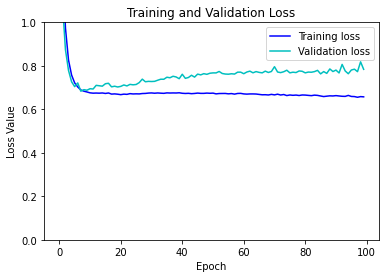

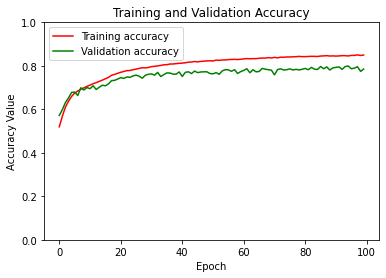

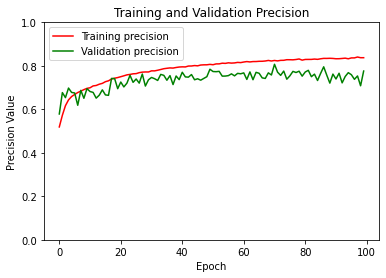

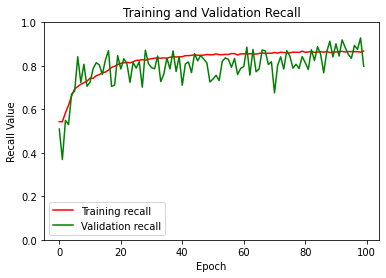

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'b', label='Training loss')
plt.plot(history.epoch, val_loss, 'c', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

##########################################################

metrics = history.history['binary_accuracy']
val_metrics = history.history['val_binary_accuracy']

plt.figure()
plt.plot(history.epoch, metrics, 'r', label='Training accuracy')
plt.plot(history.epoch, val_metrics, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

##########################################################

metrics = history.history['precision']
val_metrics = history.history['val_precision']

plt.figure()
plt.plot(history.epoch, metrics, 'r', label='Training precision')
plt.plot(history.epoch, val_metrics, 'g', label='Validation precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

##########################################################

metrics = history.history['recall']
val_metrics = history.history['val_recall']

plt.figure()
plt.plot(history.epoch, metrics, 'r', label='Training recall')
plt.plot(history.epoch, val_metrics, 'g', label='Validation recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Evaluate Model

## Human testing

In [23]:
_, acc, prec, recall = model.evaluate(X_test_human_comb, y_test_human_comb, verbose=2)
print("\n**** HUMAN ****\nAccuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%".format(acc*100, prec*100, recall*100))

166/166 - 3s - loss: 0.9520 - binary_accuracy: 0.7116 - precision: 0.7690 - recall: 0.6050

**** HUMAN ****
Accuracy: 71.16%
Precision: 76.90%
Recall: 60.50%


## Mouse testing

In [24]:
_, acc, prec, recall = model.evaluate(X_test_mouse_comb, y_test_mouse_comb, verbose=2)
print("\n**** Mouse ****\nAccuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%".format(acc*100, prec*100, recall*100))

166/166 - 2s - loss: 0.9366 - binary_accuracy: 0.7239 - precision: 0.7938 - recall: 0.6050

**** Mouse ****
Accuracy: 72.39%
Precision: 79.38%
Recall: 60.50%


# Reset Model

In [25]:
'''Uncomment to reset tensorflow graphs'''
# tf.keras.backend.clear_session()

'Uncomment to reset tensorflow graphs'